**Author**: JW Debelius (justine.debelius@ki.se)<br>
**Date**: September 2021<br>
**Enviroment**: `qiime2-2021.8-dev`<br>
**Python version**: 3.8<br>
**Extra packages**: None<br>
**QIIME version**: 2021.8-dev<br>
**Extra Plugins**: q2-sidle (memory refactor); RESCRIPt (v. )

# Mock Community Data Preperation

## Background

This notebook will process four mock community samples sequenced with the Ion torrent metagenomic kit, originally published by [Barb et al, 2015](https://pubmed.ncbi.nlm.nih.gov/26829716/). In the original paper, the authors profiled four mock communites using the 6 primer proprietary Ion Torrent kit. This kit using 6 primer pairs to target 7 regions along the 16Ss gene with both forward and reverse reads possible.
* V2
* V4
* V8
* V3
* V67
* V9

In the original paper, the authors compared the performance for each region compared to the baseline. They clusstered sequences into de novo OTUs clustered with UPARSE; taxonomic assignment was made in QIIME 1 and then compared using abundance profiling, and deviation from published Shannon diversity. 

## Data download and avaliability

Sequences were deposided in SRA under accession SUB1054354. We used the [SRA CLI tools]() to download the sequences and the provided sample sheet. Sequence fastq files and the description were saved in the `mock` folder in the `data/input` directory. 

When they were deposited, the sequences were demultiplexed by sample, but not by region. The Ion Torrent kit produced reads for 12 regions (6forward and 6 reverse), meaning that to be able to use the sequences here, we need to split them into regions.

## Preprocessing Approach

For the sake of not hating everyone and everything in existing, we will take a somewhat less optimal approach and try to do a regional demux on  already denoised sequences, because otherwise both I and my computer willcry.         
So, Sequenced are prepared through the following steps: 

1. Sequences from each sample are filtered based on read length into batches based on read length. For this, we'll use 150, 200, 250, and 300 nt reads.
2. Import reads for each length using the manifest format 
3. Denoise the per-region sequences to their fixed read length using dada2-pyro which better handles the error profile. Trim the reads to the approriate read length during sequencing. 
4. Use RESCRIPt to orient the sequences so they have a consistent orientation
5. Align the reads against the reference sequences to seperate them into regions
6. Identify he regions through some kind of witch craft
7. Filter the sequences into samples and regions
8. Account for all the sequences that were lost during filtering, aligning, 
<!-- 9. Consider life choices and decide why there is such an obsession with mock communitites -->

## Set up

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skbio

%matplotlib inline

from qiime2 import Artifact, Metadata, Visualization

In [2]:
input_dir = 'data/inputs/mock/' # modify if you've placed the files in another location
output_dir = 'data/output/mock/' # Change this if you want a different output

In [3]:
read_lengths = np.array([200])
# read_lengths = np.array([200])

In [4]:
steps = {
    'split_by_length': {
        'run': True,
        'overwrite': True,
        'input_dir': input_dir,
        'output_dir': os.path.join(output_dir, '1.split_length')
    },
    'import_seqs': {
        'run': True,
        'overwrite': True,
        'input_dir': os.path.join(output_dir, '1.split_length'),
        'output_dir': os.path.join(output_dir, '2.split_manifest'),
    },
    'denoise_seqs': {
        'run': True,
        'overwrite': True,
        'input_dir':  os.path.join(output_dir, '2.split_manifest'),
        'output_dir':  os.path.join(output_dir, '3.denoised'),
    },
    'cluster_orientation': {
        'run': True,
        'overwrite': True,
        'input_dir': os.path.join(output_dir, '3.denoised'),
        'output_dir': os.path.join(output_dir, '4.sequence_orientation'),
        'reference_fp': 'data/reference/gg_13_8_88/88_otus.qza',
    },
    'align_to_reference': {
        'run': True,
        'overwrite': True,
        'input_dir':  os.path.join(output_dir, '4.sequence_orientation'),
        'output_dir': os.path.join(output_dir, '5.aligned_to_ref'),
        'reference_fp': 'data/reference/gg_13_8_88/gg_88_otus_aligned.qza',
    }
}

In [5]:
samples = [fp.split('.')[0] for fp in os.listdir(input_dir)
           if (os.path.splitext(fp)[1] == '.fastq') & ('_1' in fp)]
samples = [samples[0]]

## Preprocessing
### Split sequences into read lengths

We'll start by splitting sequences into batches based on the read lengths. For each sample,
we'll load the sequences, determine the read lengths, and then group the sequences according to the read lengths provided. 

In [132]:
def batch_sequence_by_length(sample, ori_fastq, output_dir, 
                             read_lengths=read_lengths):
    """
    Splits sequences in batches based on read on read lengths
    """
    # Loads the file
    seqs_with_qual = skbio.io.read(ori_fastq, 
                               format='fastq', 
                               phred_offset=33,
                               )
    # Determines the length and reads in the sequence
    seq_lengths = pd.DataFrame.from_dict(orient='index', data={
        seq.metadata['id']: {'seq': seq,
                             'length': len(seq),
                             }
        for seq in seqs_with_qual
    })
    # Groups the ssequences into batches based on the read lengths
    seq_group = pd.concat(axis=1, objs=[(seq_lengths['length'] > (length)) * 1 
                          for length in read_lengths]).sum(axis=1)
    seq_group.replace({i + 1: length for i, length in enumerate(read_lengths)},
                       inplace=True)
    seq_lengths['batch'] = seq_group
    
    seq_batches = \
        seq_lengths.groupby('batch', sort=False)['seq'].apply(lambda x: x.values)
    seq_batches = seq_batches.loc[read_lengths]
    
    for length, reads in seq_batches.iteritems():
        fp_ = f'{output_dir}/{length}.fastq'
        f_ = skbio.io.open(fp_, 'w')
        for seq in reads:
            seq.write(f_, format='fastq', phred_offset=33)

In [133]:
step_overwrite = steps['split_by_length']['overwrite']
step_output_dir = steps['split_by_length']['output_dir']

os.makedirs(step_output_dir, exist_ok=step_overwrite)

In [134]:
for sample in samples:
    print(sample)

    # Sets up the sample path and output directory
    ori_fastq = os.path.join(input_dir, f'{sample}.fastq')
    sample_dir = os.path.join(step_output_dir, sample)
    os.makedirs(sample_dir, exist_ok=step_overwrite)

    # Batches the sequences 
    batch_sequence_by_length(sample, ori_fastq, sample_dir, read_lengths)

SRR2182221_1


### Import the data into QIIME 2 using a manifest format

Having split the data from each sample by read length, we'll 

In [135]:
def build_manifest(samples, read_length):
    """
    Builds a sample manifest for a specified read length
    """
    manifest = pd.DataFrame.from_dict(orient='index', data={
        sample: {
            'absolute-filepath': os.path.abspath(f'{manifest_input_dir}/'
                                                 f'{sample}/{read_length}.fastq')
        }
        for sample in samples
    })
    manifest.index.set_names('sample-id', inplace=True)
    return Metadata(manifest)

In [136]:
manifest_input_dir = step_output_dir
manifest_output_dir = steps['import_seqs']['output_dir']
manifest_overwrite = steps['import_seqs']['overwrite']

os.makedirs(manifest_output_dir, exist_ok=manifest_overwrite)



In [137]:
for read_length in read_lengths:
    manifest_fp = f'{manifest_output_dir}/manifest_{read_length}.tsv'
    seqs_art_fp = f'{manifest_output_dir}/demux_reads_{read_length}.qza'
    seqs_vis_fp = f'{manifest_output_dir}/demux_reads_{read_length}.qzv'

    manifest = build_manifest([samples[0]], read_length)
    manifest.save(manifest_fp)
    
    !qiime tools import \
      --type 'SampleData[SequencesWithQuality]' \
      --input-path $manifest_fp \
      --output-path $seqs_art_fp \
      --input-format SingleEndFastqManifestPhred33V2

    !qiime demux summarize \
     --i-data $seqs_art_fp \
     --o-visualization $seqs_vis_fp

Imported data/output/mock/2.split_manifest/manifest_200.tsv as SingleEndFastqManifestPhred33V2 to data/output/mock/2.split_manifest/demux_reads_200.qza
Saved Visualization to: data/output/mock/2.split_manifest/demux_reads_200.qzv


### Denoise sequences

In [138]:
denoised_output = steps['denoise_seqs']['output_dir']
denoised_overwrite = steps['denoise_seqs']['overwrite']
os.makedirs(denoised_output, exist_ok=denoised_overwrite)

In [139]:
for read_length in read_lengths:
    seqs_art_fp = f'{manifest_output_dir}/demux_reads_{read_length}.qza'
    table_art_fp = f'{denoised_output}/table_{read_length}.qza'
    rep_seq_art_fp = f'{denoised_output}/rep_seq_{read_length}.qza'
    stats_art_fp = f'{denoised_output}/denosing_stats_{read_length}.qza'
    table_viz_fp = f'{denoised_output}/table_{read_length}.qzv'
    stats_viz_fp = f'{denoised_output}/denosing_stats_{read_length}.qzv'
    
    !qiime dada2 denoise-pyro \
     --i-demultiplexed-seqs $seqs_art_fp \
     --p-trunc-len $read_length \
     --p-hashed-feature-ids \
     --o-table $table_art_fp \
     --o-representative-sequences $rep_seq_art_fp \
     --o-denoising-stats $stats_art_fp
    
    !qiime metadata tabulate \
     --m-input-file $stats_art_fp \
     --o-visualization $stats_viz_fp
    
    !qiime feature-table summarize \
     --i-table $table_art_fp \
     --o-visualization $table_viz_fp

Saved FeatureTable[Frequency] to: data/output/mock/3.denoised/table_200.qza
Saved FeatureData[Sequence] to: data/output/mock/3.denoised/rep_seq_200.qza
Saved SampleData[DADA2Stats] to: data/output/mock/3.denoised/denosing_stats_200.qza
Saved Visualization to: data/output/mock/3.denoised/denosing_stats_200.qzv
Saved Visualization to: data/output/mock/3.denoised/table_200.qzv


## Regional Demultiplexing


### Re-orient the data

We'll reorient the data using the rescript `orient-seqs` function which takes sequences, orients them against a reference set so they're all in the same alignment, and discards anything that can't be aligned properly.


In [140]:
orient_input_dir = steps['cluster_orientation']['input_dir']
orient_output_dir = steps['cluster_orientation']['output_dir']
orient_overwrite = steps['cluster_orientation']['overwrite']
orient_ref_fp = steps['cluster_orientation']['reference_fp']

os.makedirs(orient_output_dir, exist_ok=orient_overwrite)

In [141]:
for read_length in read_lengths:
    input_seqs = f'{orient_input_dir}/rep_seq_{read_length}.qza'
    output_match_fp =  f'{orient_output_dir}/rep_seq_oriented_{read_length}.qza'
    output_seqs_discard = f'{orient_output_dir}/disoriented_{read_length}.qza'

    !qiime rescript orient-seqs \
     --i-sequences $input_seqs \
     --i-reference-sequences $orient_ref_fp \
     --p-perc-identity 0.8 \
     --o-oriented-seqs $output_match_fp \
     --o-unmatched-seqs $output_seqs_discard

Saved FeatureData[Sequence] to: data/output/mock/4.sequence_orientation/rep_seq_oriented_200.qza
Saved FeatureData[Sequence] to: data/output/mock/4.sequence_orientation/disoriented_200.qza


### Align to a reference sequence

We'll use MAFTT to align the sequences to the reference database.

In [6]:
align_ref_input_dir = steps['align_to_reference']['input_dir']
align_ref_output_dir = steps['align_to_reference']['output_dir']
align_ref_overwrite = steps['align_to_reference']['overwrite']
align_ref_align_fp = steps['align_to_reference']['reference_fp']

os.makedirs(align_ref_output_dir, exist_ok=align_ref_overwrite)

In [7]:
!qiime tools import --show-importable-formats | grep Tax

HeaderlessTSVTaxonomyDirectoryFormat
HeaderlessTSVTaxonomyFormat
SILVATaxidMapDirectoryFormat
SILVATaxidMapFormat
SILVATaxonomyDirectoryFormat
SILVATaxonomyFormat
TSVTaxonomyDirectoryFormat
TSVTaxonomyFormat
TaxonomicClassiferTemporaryPickleDirFmt


In [8]:
!qiime tools import \
 --type 'FeatureData[Taxonomy]' \
 --input-format HeaderlessTSVTaxonomyFormat \
 --input-path data/reference/gg_13_8_88/88_otu_taxonomy.txt \
 --output-path data/reference/gg_13_8_88/88_otu_taxonomy.qza

Imported data/reference/gg_13_8_88/88_otu_taxonomy.txt as HeaderlessTSVTaxonomyFormat to data/reference/gg_13_8_88/88_otu_taxonomy.qza


In [9]:
ref_seqs_q2 = Artifact.load(align_ref_align_fp)
ref_taxa_q2 = Artifact.load('data/reference/gg_13_8_88/88_otu_taxonomy.qza')

In [10]:
ref_seqs_q2

<artifact: FeatureData[AlignedSequence] uuid: f87e33c2-8105-49ea-82db-e9d0afc26a99>

In [11]:
import qiime2.plugins.taxa.actions as q2_taxa
import qiime2.plugins.alignment.actions as q2_align
import qiime2.plugins.rescript.actions as q2_rescript

In [12]:
ref_seqs = ref_seqs_q2.view(pd.Series)
ref_taxa = ref_taxa_q2.view(pd.Series)

In [26]:
proteo_ref_ids = ref_taxa.index[ref_taxa.apply(lambda x: 'f__Enterobacteriaceae' in x)]
proteo_ref = ref_seqs.loc[proteo_ref_ids]
sub_ref_seqs = Artifact.import_data('FeatureData[AlignedSequence]',
                                    proteo_ref,
                                    pd.Series)


In [28]:
sequences = Artifact.load('data/output/mock/4.sequence_orientation/rep_seq_oriented_200.qza')
expanded = q2_align.mafft_add(alignment=sub_ref_seqs, sequences=sequences).expanded_alignment

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: mafft --preservecase --inputorder --thread 1 --add /var/folders/bw/q064ds0d2795_6mxnrssf0l1gkw0rj/T/qiime2-archive-5p5dkh6x/3b2e34ed-dc78-45be-b35d-9b131fe8cad1/data/dna-sequences.fasta /var/folders/bw/q064ds0d2795_6mxnrssf0l1gkw0rj/T/qiime2-archive-8sa318xz/7431b0f4-d554-4cce-9a4e-94484954fb06/data/aligned-dna-sequences.fasta



In [86]:
!qiime quality-control bowtie2-build --help

Usage: qiime quality-control bowtie2-build [OPTIONS]

  Build bowtie2 index from reference sequences.

Inputs:
  --i-sequences ARTIFACT FeatureData[Sequence]
                          Reference sequences used to build bowtie2 index.
                                                                    [required]
Parameters:
  --p-n-threads INTEGER   Number of threads to launch
    Range(1, None)                                                [default: 1]
Outputs:
  --o-database ARTIFACT   Bowtie2 index.
    Bowtie2Index                                                    [required]
Miscellaneous:
  --output-dir PATH       Output unspecified results to a directory
  --verbose / --quiet     Display verbose output to stdout and/or stderr
                          during execution of this action. Or silence output
                          if execution is successful (silence is golden).
  --examples              Show usage examples and exit.
  --citations             Show citations and exit.


In [76]:
expanded_df = expanded.view(pd.Series).apply(lambda x: pd.Series(list(str(x))))
expanded_df.drop(proteo_ref.index, inplace=True)
expanded_df.replace({'-': np.nan}, inplace=True)
# expanded_df.dropna(axis=1, how='all', inplace=True)

In [77]:
coverage_df = expanded_df.notna()

In [78]:
coverage_counts = coverage_df.sum()

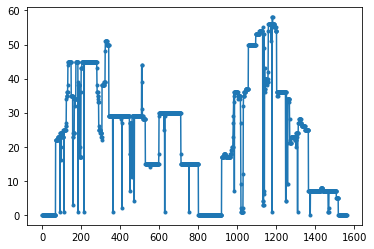

In [79]:
plt.plot(coverage_counts.index, coverage_counts.values, '.-')
# plt.plot(coverage_counts.index, coverage_counts.rolling(10).mean())

In [66]:
seq_split_left = expanded_df[expanded_df.columns[expanded_df.columns < 850]].copy()
seq_split_right = expanded_df[expanded_df.columns[expanded_df.columns >= 850]].copy()


In [68]:
seq_split_right.dropna(how='all', axis=1, inplace=True)

In [74]:
seq_split_right.notna().sum().diff().sort_values()

1178   -54.0
1131   -51.0
1138   -43.0
1248   -32.0
985    -29.0
        ... 
1250    32.0
1140    36.0
1136    50.0
1179    57.0
920      NaN
Length: 597, dtype: float64

In [ ]:
!qiime alignment mafft-add \
 --i-alignment $align_ref_align_fp \
 --i-sequences data/output/mock/4.sequence_orientation/rep_seq_oriented_200.qza \
 --p-n-threads 2 \
 --o-expanded-alignment $align_ref_output_dir/align_200.qza

And then, we need some way to pull the sequences out and figure out their aligned position.

In [ ]:
aligned_seqs_q2 = Artifact.load('data/output/mock/5.aligned_to_ref/align_200.qza')
test_seqs_q2 = Artifact.load('data/output/mock/4.sequence_orientation/rep_seq_oriented_200.qza')
reference_taxa_q2 = Artifact.load('data/reference/gg_13_8_88/88_otu_taxonomy.qza')

In [ ]:
aligned_series = aligned_seqs_q2.view(pd.Series)
test_seqs = test_seqs_q2.view(pd.Series)
aligned_taxa = reference_taxa_q2.view(pd.Series)

In [ ]:
proteo_ref_ids = aligned_taxa.loc[aligned_taxa.apply(lambda x: 'f__Enterobacteriaceae' in x)]

In [ ]:
check_seqs = np.hstack([proteo_ref_ids.index.values, test_seqs.index.values])

In [ ]:
aligned_series = aligned_series.loc[check_seqs]

In [ ]:
aligned_df = aligned_series.astype(str).apply(lambda x: pd.Series(list(x)))
aligned_df.replace({'-': np.nan}, inplace=True)
# degaps the sequences
aligned_df.dropna(how='all', axis=1, inplace=True)

In [ ]:
aligned_df

In [ ]:
ranked_position = aligned_df.notna().sum(axis=0).sort_index()

In [ ]:
ax = plt.plot(ranked_position.index, ranked_position.values, '.')
plt.plot(ranked_position.index, ranked_position.rolling(8).median(), '-', markersize=5)

In [ ]:
ranked_position.sort_values(ascending=False)